# Resonances of a beam clamped at one end

- Eigenmodes
- 3D
- Comparison with beam theory

This example is adapted from (legacy Fenics):  
&emsp; https://comet-fenics.readthedocs.io/en/latest/demo/modal_analysis_dynamics/cantilever_modal.html  
where extensive explanations are given. Here we show how `elastodynamicsx` can be used to reproduce it.

It is also inspired from (Fenicsx):  
&emsp; https://mikics.github.io/gsoc-jupyterbook/chapter3/demo_half_loaded_waveguide.html

In [1]:
import numpy as np

from dolfinx import mesh, fem, default_scalar_type
from mpi4py import MPI
from petsc4py import PETSc

from elastodynamicsx.pde import material, boundarycondition, PDE
from elastodynamicsx.solvers import EigenmodesSolver
from elastodynamicsx.utils import make_facet_tags

#import pyvista
#pyvista.start_xvfb()
#pyvista.set_jupyter_backend("static")

### FE domain

In [2]:
L_, B_, H_ = 20., 0.5, 1.  # Lengths

# Nb of elts.
Nx = 20
Ny = int(B_/L_ * Nx) + 1
Nz = int(H_/L_ * Nx) + 1

extent = [[0., 0., 0.], [L_, B_, H_]]

# create the mesh
domain = mesh.create_box(MPI.COMM_WORLD, extent, [Nx, Ny, Nz])

# create the function space
V = fem.FunctionSpace(domain, ("Lagrange", 2, (domain.geometry.dim,)))

# define some tags
tag_left, tag_top, tag_right, tag_bottom, tag_back, tag_front = 1, 2, 3, 4, 5, 6
boundaries = [(tag_left  , lambda x: np.isclose(x[0], 0 )),\
              (tag_right , lambda x: np.isclose(x[0], L_)),\
              (tag_bottom, lambda x: np.isclose(x[1], 0 )),\
              (tag_top   , lambda x: np.isclose(x[1], B_)),\
              (tag_back  , lambda x: np.isclose(x[2], 0 )),\
              (tag_front , lambda x: np.isclose(x[2], H_))]

facet_tags = make_facet_tags(domain, boundaries)

### Boundary condition
Clamp the left face of the beam

In [3]:
bc_clamp = boundarycondition((V, facet_tags, tag_left), 'Clamp')

### Define the material law
isotropic elasticity

In [4]:
# Parameters here...
E, nu = 1e5, 0.
rho = 1e-3
# ... end

# Scaling
scaleRHO = 1e6  # a scaling factor to avoid blowing the solver
scaleFREQ= np.sqrt(scaleRHO)  # the frequencies must be scaled accordingly
rho *= scaleRHO

# Convert Young & Poisson to Lamé's constants
lambda_ = E * nu / (1 + nu) / (1 - 2 * nu)
mu      = E / 2 / (1 + nu)

# Convert floats to fem.Constant
rho     = fem.Constant(domain, default_scalar_type(rho))
lambda_ = fem.Constant(domain, default_scalar_type(lambda_))
mu      = fem.Constant(domain, default_scalar_type(mu))

material = material(V, 'isotropic', rho, lambda_, mu)

### Assemble the PDE

In [5]:
pde = PDE(V, materials=[material], bodyforces=[], bcs=[bc_clamp])

### Solve

In [6]:
# ## Initialize the solver; prepare to solve for 6 eigenvalues
M = pde.M()  # mass matrix (PETSc)
C = None  # None to ensure no damping
K = pde.K()  # stiffness matrix (PETSc)
eps = EigenmodesSolver(V.mesh.comm, M, C, K, nev=6)

In [7]:
# ## Run the big calculation!
eps.solve()
# ## End of big calc.

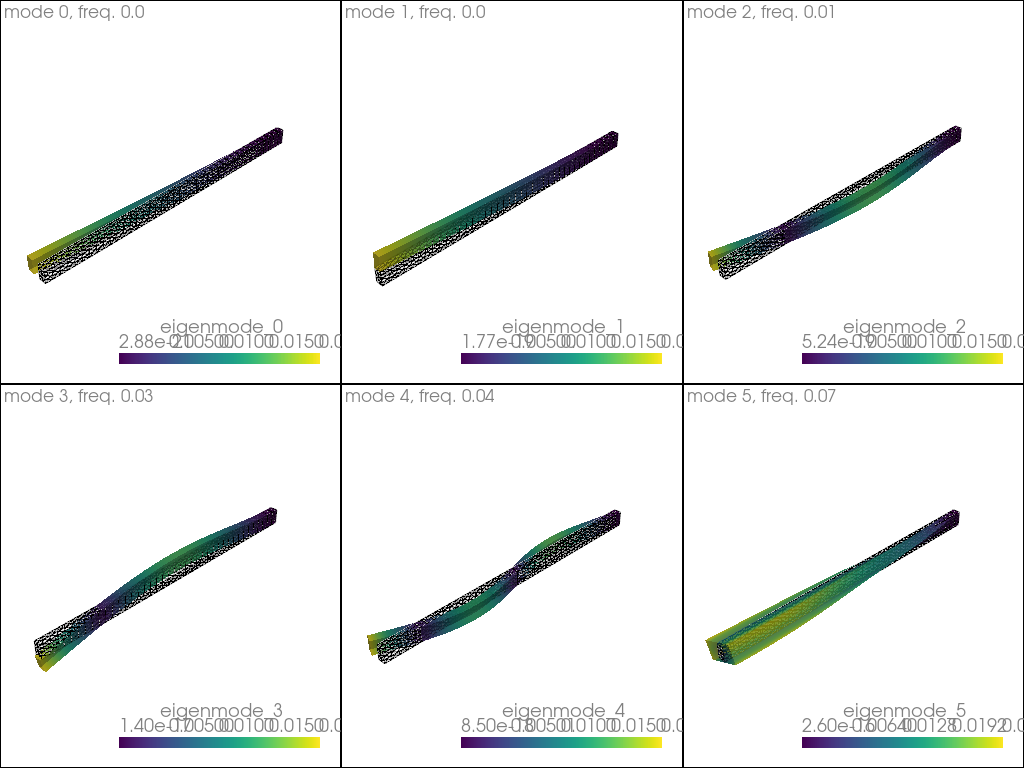

In [8]:
# ## Get the result
# eps.printEigenvalues()
eigenfreqs = eps.getEigenfrequencies()
# eigenmodes = eps.getEigenmodes()

eps.plot(V, wireframe=True, factor=50)

### Compare with beam theory
$\omega_n = \alpha_n^2 \sqrt{\frac{E I}{\rho S L^4}}$, with $S$ the cross section, $I$ the bending inertia, and $\alpha_n$ the $n^\mathrm{th}$ solution of $\cos\alpha \cosh\alpha +1 =0$.

In [9]:
# Exact solution computation
from scipy.optimize import root
from math import cos, cosh
falpha = lambda x: cos(x)*cosh(x)+1
alpha  = lambda n: root(falpha, (2*n+1)*np.pi/2)['x'][0]

In [10]:
nev = eigenfreqs.size
I_bend = H_*B_**3/12*(np.arange(nev)%2==0) + B_*H_**3/12*(np.arange(nev)%2==1)
freq_beam = np.array([alpha(i//2) for i in range(nev)])**2 *np.sqrt(E*I_bend/(rho.value*B_*H_*L_**4))/2/np.pi

In [11]:
print('Eigenfrequencies: comparison with beam theory\n')
print('mode || FE (Hz)\t|| Beam theory (Hz)\t|| Difference (%)')
for n in range(len(eigenfreqs)):
    fe = eigenfreqs[n] * scaleFREQ
    bt = freq_beam[n] * scaleFREQ
    print(f'{n+1}    || {fe:.4f}\t|| {bt:.4f}        \t|| {100*(fe-bt)/fe:.1f}')

Eigenfrequencies: comparison with beam theory

mode || FE (Hz)	|| Beam theory (Hz)	|| Difference (%)
1    || 2.0190	|| 2.0193        	|| -0.0
2    || 4.0324	|| 4.0385        	|| -0.2
3    || 12.6452	|| 12.6544        	|| -0.1
4    || 25.0451	|| 25.3089        	|| -1.1
5    || 35.3717	|| 35.4328        	|| -0.2
6    || 68.8365	|| 70.8655        	|| -2.9
